# Loan Data from Prosper
## by Suelen Fenali

## Preliminary Wrangling

The data used for this analyze contains around 114k loans with 81 variables. I will work with

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

* 0 - Not Available
* 1 - Debt Consolidation
* 2 - Home Improvement
* 3 - Business
* 4 - Personal Loan
* 5 - Student Use
* 6 - Auto
* 7 - Other
* 8 - Baby&Adoption
* 9 - Boat
* 10 - Cosmetic Procedure
* 11 - Engagement Ring
* 12 - Green Loans
* 13 - Household Expenses
* 14 - Large Purchases
* 15 - Medical/Dental
* 16 - Motorcycle
* 17 - RV
* 18 - Taxes
* 19 - Vacation
* 20 - Wedding Loans


### Gather

In [2]:
loan_data = pd.read_csv('prosperLoanData.csv')
dictionary = pd.read_csv('dictionary.csv')

In [3]:
dictionary.head()

,variable,description
0,ListingKey,"Unique key for each listing, same value as the..."
1,ListingNumber,The number that uniquely identifies the listin...
2,ListingCreationDate,The date the listing was created.
3,CreditGrade,The Credit rating that was assigned at the tim...
4,Term,The length of the loan expressed in months.


### Assess

In [4]:
loan_data = loan_data[['ListingCreationDate', 'Term', 'LoanStatus', 'BorrowerAPR',
             'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
             'EstimatedReturn', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)',
             'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
             'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'LoanOriginalAmount',
             'PercentFunded', 'Investors']]

In [5]:
for c in loan_data.columns:
    print(f'{c}: {dictionary[dictionary.variable == c].description.values[0]}')
    print("-" * 100, '\n')

ListingCreationDate: The date the listing was created.
---------------------------------------------------------------------------------------------------- 

Term: The length of the loan expressed in months.
---------------------------------------------------------------------------------------------------- 

LoanStatus: The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
---------------------------------------------------------------------------------------------------- 

BorrowerAPR: The Borrower's Annual Percentage Rate (APR) for the loan.
---------------------------------------------------------------------------------------------------- 

BorrowerRate: The Borrower's interest rate for this loan. 
---------------------------------------------------------------------------------------------------- 

LenderYield: The Lender yield on the loan. Lender yiel

In [6]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 22 columns):
ListingCreationDate          113937 non-null object
Term                         113937 non-null int64
LoanStatus                   113937 non-null object
BorrowerAPR                  113912 non-null float64
BorrowerRate                 113937 non-null float64
LenderYield                  113937 non-null float64
EstimatedEffectiveYield      84853 non-null float64
EstimatedLoss                84853 non-null float64
EstimatedReturn              84853 non-null float64
ProsperRating (Alpha)        84853 non-null object
ProsperScore                 84853 non-null float64
ListingCategory (numeric)    113937 non-null int64
Occupation                   110349 non-null object
EmploymentStatus             111682 non-null object
EmploymentStatusDuration     106312 non-null float64
IsBorrowerHomeowner          113937 non-null bool
CurrentDelinquencies         113240 non-null float64
Amoun

#### Documentation
- The columns `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn`, `ProsperRating (Alpha)`, `ProsperScore` have data available just after 2009, for this reason I will delete the data from previous years.
- The following columns have missing values: `Occupation`, `EmploymentStatus`, `EmploymentStatusDuration`, `CurrentDelinquencies`, `AmountDelinquent`, `DelinquenciesLast7Years`.
- ListingCreationDate has a wrong data type.
- ListingCategory is the numeric representation for categories. It can be changed to have more semantic values.

### Clean

*Many of the chosen data is available just after 2009, for this reason I will delete the data from previous years.*

#### Define
Remove all lines that don't have values for the columns `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn`, `ProsperRating (Alpha)`, `ProsperScore`.

#### Code

In [7]:
loan = loan_data[~loan_data['EstimatedEffectiveYield'].isna()]

#### Test

In [8]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84853 entries, 1 to 113936
Data columns (total 22 columns):
ListingCreationDate          84853 non-null object
Term                         84853 non-null int64
LoanStatus                   84853 non-null object
BorrowerAPR                  84853 non-null float64
BorrowerRate                 84853 non-null float64
LenderYield                  84853 non-null float64
EstimatedEffectiveYield      84853 non-null float64
EstimatedLoss                84853 non-null float64
EstimatedReturn              84853 non-null float64
ProsperRating (Alpha)        84853 non-null object
ProsperScore                 84853 non-null float64
ListingCategory (numeric)    84853 non-null int64
Occupation                   83520 non-null object
EmploymentStatus             84853 non-null object
EmploymentStatusDuration     84834 non-null float64
IsBorrowerHomeowner          84853 non-null bool
CurrentDelinquencies         84853 non-null float64
AmountDelinquent  

*The following columns have missing values: Occupation, EmploymentStatus, EmploymentStatusDuration, CurrentDelinquencies, AmountDelinquent, DelinquenciesLast7Years.*

The only column still missing value is `Occupation`.

#### Define

#### Code

In [9]:
loan.EmploymentStatus.value_counts()

Employed         67310
Full-time         7927
Self-employed     4538
Other             3806
Not employed       649
Retired            367
Part-time          256
Name: EmploymentStatus, dtype: int64

In [10]:
loan[loan.Occupation.isna()].EmploymentStatus.value_counts()

Other        1332
Full-time       1
Name: EmploymentStatus, dtype: int64

---
*ListingCategory is the numeric representation for categories. It can be changed to have more semantic values.*

#### Define
Create a DataFrame with the correspondent semantic values, and change the categories code to them.

#### Code

In [11]:
listing_categories = {'code_category': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                      'ListingCategory': ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business',
                               'Personal Loan', 'Student Use', 'Auto', 'Other', 'Baby&Adoption', 'Boat',
                               'Cosmetic Procedure', 'Engagement Ring', 'Green Loans', 'Household Expenses',
                               'Large Purchases', 'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                               'Wedding Loans']}

listing_cat = pd.DataFrame(listing_categories)

In [12]:
loan.shape

(84853, 22)

In [13]:
loan.rename(columns={'ListingCategory (numeric)': 'code_category'}, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [14]:
loan = loan.merge(listing_cat, on='code_category', how='left')

#### Test

In [15]:
loan.shape

(84853, 23)

In [16]:
loan.sample(3, random_state=13)

,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,code_category,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,LoanOriginalAmount,PercentFunded,Investors,ListingCategory
37547,2012-09-13 11:22:03.957000000,60,Current,0.15936,0.1364,0.1264,0.12590,0.0249,0.10100,A,8.0,1,Professional,Employed,154.0,True,5.0,38432.0,15.0,20919,1.0,22,Debt Consolidation
56659,2014-01-10 17:01:02.063000000,60,Current,0.18197,0.1585,0.1485,0.13953,0.0624,0.07713,C,7.0,1,Professional,Employed,185.0,False,1.0,0.0,0.0,10000,1.0,1,Debt Consolidation
15368,2013-08-09 15:01:01.580000000,60,Current,0.31293,0.2862,0.2762,0.25190,0.1275,0.12440,E,2.0,1,Other,Employed,178.0,False,0.0,0.0,0.0,4000,1.0,26,Debt Consolidation


### What is the structure of your dataset?



### What is/are the main feature(s) of interest in your dataset?

> Your answer here!

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Your answer here!

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [17]:
loan.columns

Index(['ListingCreationDate', 'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (Alpha)', 'ProsperScore', 'code_category', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'LoanOriginalAmount', 'PercentFunded', 'Investors', 'ListingCategory'], dtype='object')

#### Numeric Variables

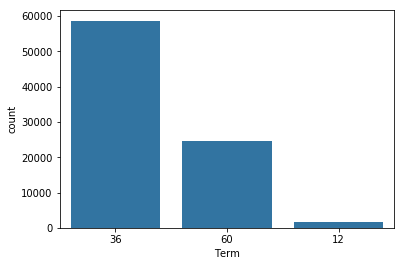

In [24]:
sb.countplot(data=loan, x='Term', order=credit_index, color=base_color);

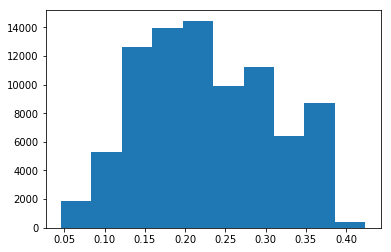

In [31]:
plt.hist(data=loan, x='BorrowerAPR');

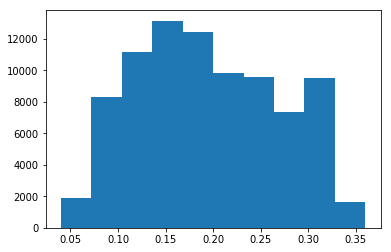

In [33]:
plt.hist(data=loan, x='BorrowerRate');

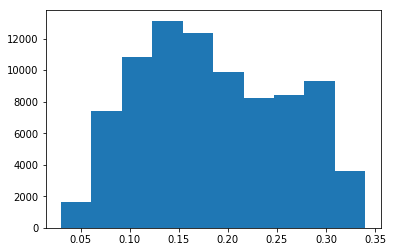

In [36]:
plt.hist(data=loan, x='LenderYield');

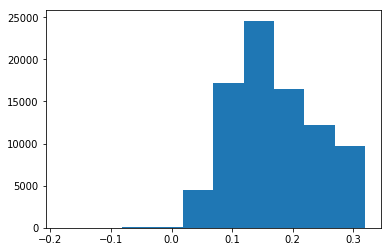

In [37]:
plt.hist(data=loan, x='EstimatedEffectiveYield');

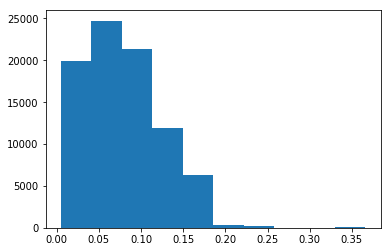

In [38]:
plt.hist(data=loan, x='EstimatedLoss');

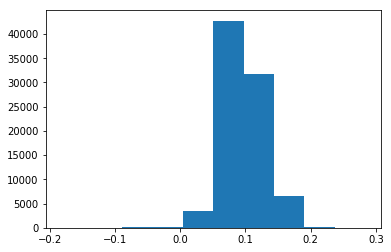

In [39]:
plt.hist(data=loan, x='EstimatedReturn');

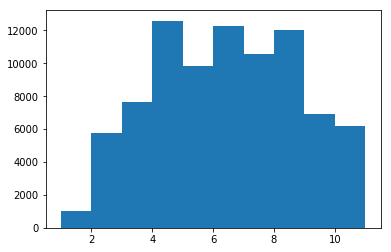

In [40]:
plt.hist(data=loan, x='ProsperScore');

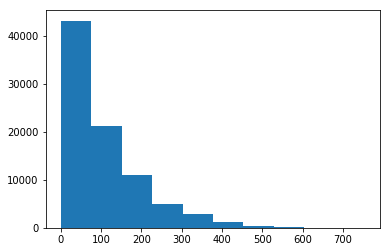

In [43]:
plt.hist(data=loan, x='EmploymentStatusDuration');

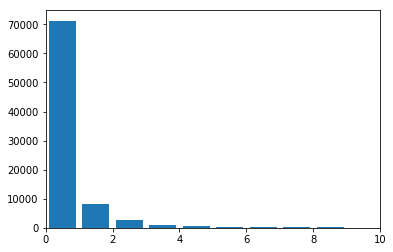

In [202]:
bins = np.arange(0, loan.CurrentDelinquencies.max()+1, 1)
plt.hist(data=loan, x='CurrentDelinquencies', bins=bins, rwidth=0.8);
plt.xlim((0,10));

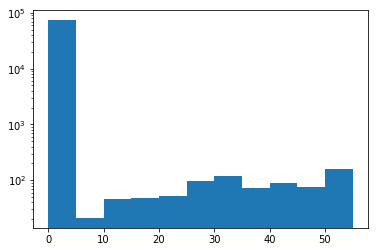

In [203]:
bins = np.arange(0, loan.CurrentDelinquencies.max()+5, 5)
plt.hist(data=loan, x='AmountDelinquent', bins=bins);
plt.yscale('log')

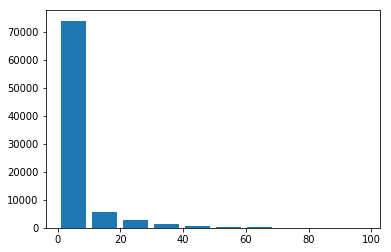

In [200]:
plt.hist(data=loan, x='DelinquenciesLast7Years', rwidth=0.8);

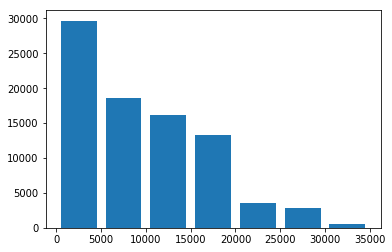

In [208]:
bins = np.arange(0, loan.LoanOriginalAmount.max()+5000, 5000)
plt.hist(data=loan, x='LoanOriginalAmount', bins=bins, rwidth=0.8);

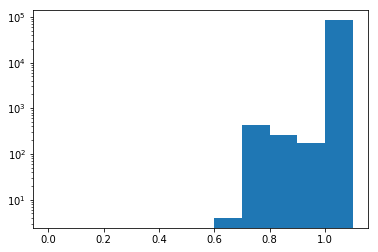

In [84]:
bins = np.arange(0, loan.PercentFunded.max()+0.1, 0.1)
plt.hist(data=loan, x='PercentFunded', bins=bins);
plt.yscale('log')

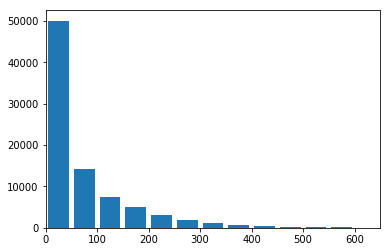

In [138]:
bins = np.arange(0, loan.Investors.max()+50, 50)
plt.hist(data=loan, x='Investors', bins=bins, rwidth=0.8);
plt.xlim((0, 650));

#### Categorical Variables

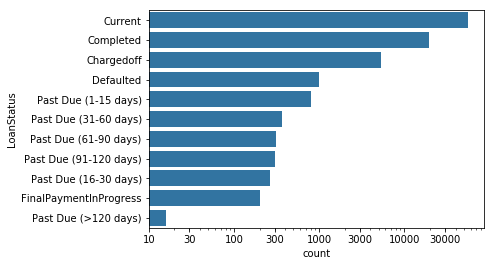

In [168]:
base_color = sb.color_palette()[0]
status_index = loan['LoanStatus'].value_counts().index
sb.countplot(data=loan, y='LoanStatus', order=status_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

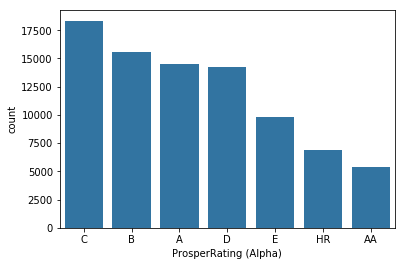

In [170]:
base_color = sb.color_palette()[0]
rating_index = loan['ProsperRating (Alpha)'].value_counts().index
sb.countplot(data=loan, x='ProsperRating (Alpha)', order=rating_index, color=base_color);

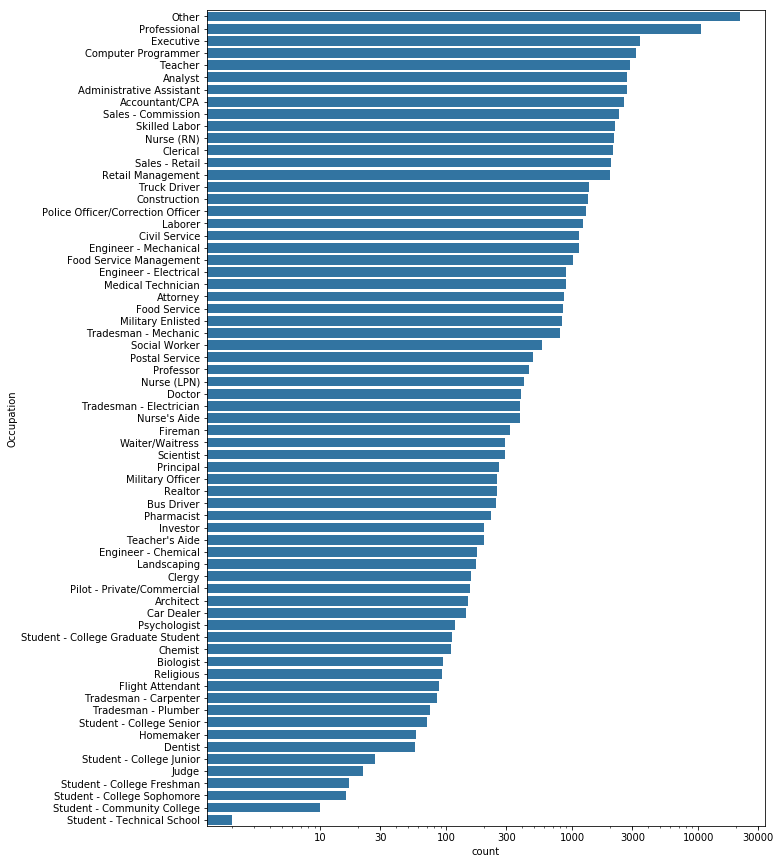

In [228]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(10, 15))
occup_index = loan['Occupation'].value_counts().index
sb.countplot(data=loan, y='Occupation', order=occup_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

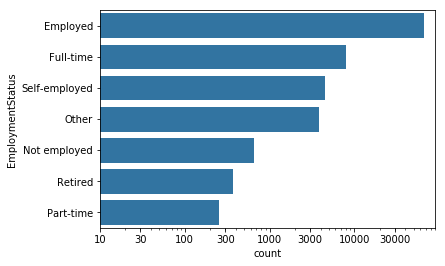

In [184]:
base_color = sb.color_palette()[0]
empl_index = loan['EmploymentStatus'].value_counts().index
sb.countplot(data=loan, y='EmploymentStatus', order=empl_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

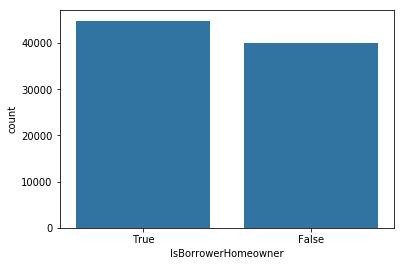

In [188]:
base_color = sb.color_palette()[0]
home_index = loan['IsBorrowerHomeowner'].value_counts().index
sb.countplot(data=loan, x='IsBorrowerHomeowner', order=home_index, color=base_color);

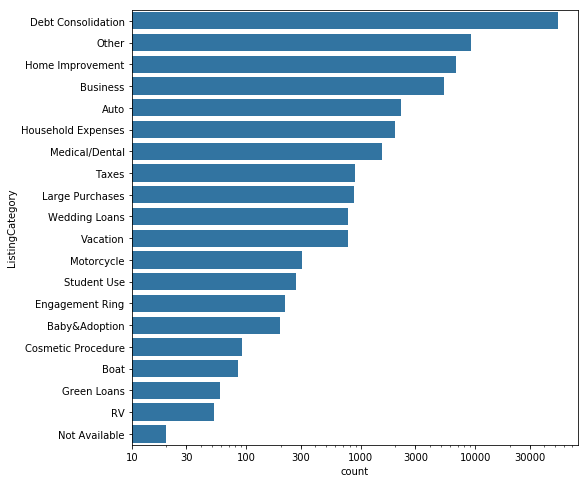

In [195]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(8,8))
categories_index = loan['ListingCategory'].value_counts().index
sb.countplot(data=loan, y='ListingCategory', order=categories_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!